In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [9]:
# We can view all of the classes that automap found


In [10]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# student: get column names of table 'Measurement'
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])
print('--------------------')
#student: check the data for Measurement table
print(engine.execute('SELECT * FROM measurement LIMIT 5').fetchall())

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]


In [13]:
#student: check the data for Station table
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])
print('--------------------')
#student: check the data for Station table
print(engine.execute('SELECT * FROM station LIMIT 5').fetchall())

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--------------------
[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
measure_time=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
measure_year=int(measure_time[0][:4])
measure_month=int(measure_time[0][5:7])
measure_date=int(measure_time[0][8:11])
timepoint=dt.date(measure_year,measure_month,measure_date)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result1=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=timepoint).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date=[x[0] for x in result1]
precipitation=[x[1] for x in result1]


In [15]:
# # #alternative way to extract timepoint

# last_date1=dt.datetime.strptime(measure_time[0], '%Y-%m-%d')
# timepointx=last_date1-dt.timedelta(days=365)

# resultx=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=timepoint).all()
# print(result1[0:5])
# print(resultx[0:5])


In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame({'Date': date, 'Precipitation':precipitation})
# Sort the dataframe by date
precipitation_df=precipitation_df.set_index(['Date'])
precipitation_df=precipitation_df.sort_index()

#student: replace NaN values with zero
precipitation_df['Precipitation']=precipitation_df['Precipitation'].fillna(0)

precipitation_df


Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.00
2016-08-23           1.79
2016-08-23           0.05
2016-08-23           0.15
...                   ...
2017-08-22           0.00
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45

[2230 rows x 1 columns]

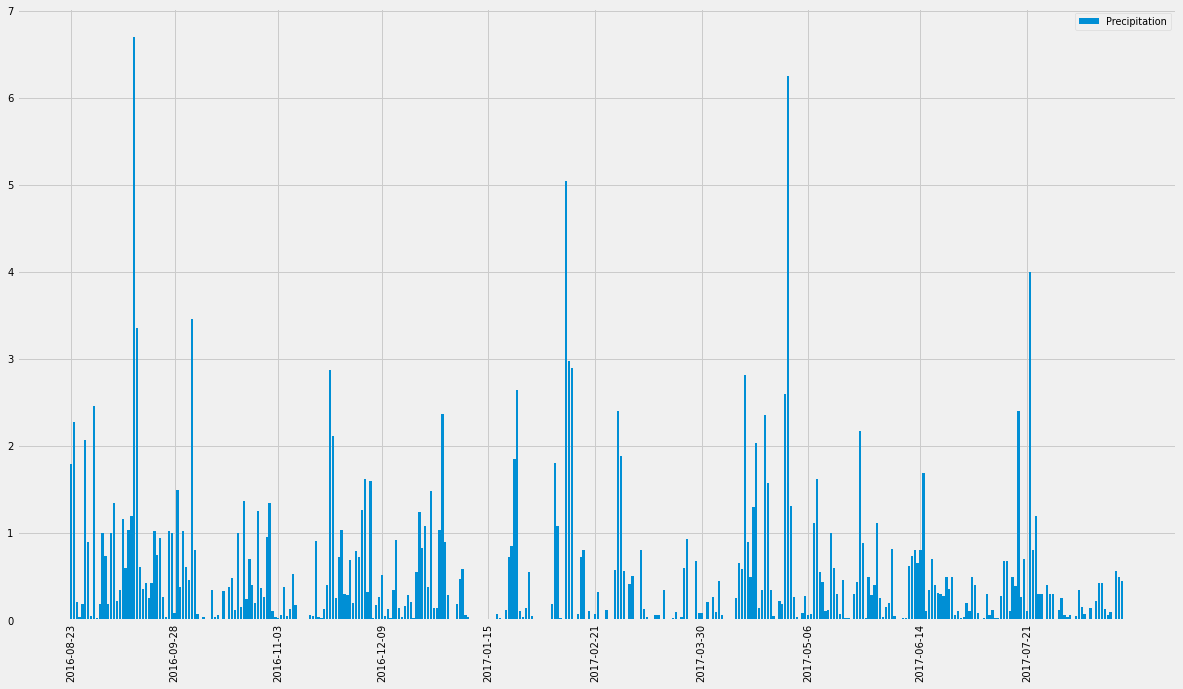

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
fig,ax=plt.subplots()
ax.bar(precipitation_df.index,precipitation_df['Precipitation'], label='Precipitation')
xticks=precipitation_df.index[::230]
ax.set_xticks(xticks)
ax.tick_params(axis='both', labelsize=10)
plt.xticks(rotation=90)
ax.legend(loc='best',fontsize='x-small')
fig.set_size_inches(18.5, 10.5)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

Precipitation
count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000

In [19]:
# Design a query to show how many stations are available in this dataset?
print(f"There are {session.query(func.count(Station.station)).scalar()} unique stations available in this dataset")


There are 9 unique stations available in this dataset


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count
active_station=station_count[0][0]
#station USC00519281 appears to be the most active station
active_station

'USC00519281'

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station==active_station).scalar()
highest_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station==active_station).scalar()
avg_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==active_station).scalar()
# df=pd.DataFrame({'Lowest Temp':[x[0] for x in lowest_temp], "Highest Temp":[x[0] for x in highest_temp], "Average Temperature":[x[0] for x in avg_temp]})

print(f'lowest temp recorded in station USC00519281 (most active station) is {lowest_temp} degrees')
print(f'highest temp recorded in station USC00519281 (most active station) is {highest_temp} degrees')
print(f'average temp recorded in station USC00519281 (most active station) is {round(avg_temp,2)} degrees')


lowest temp recorded in station USC00519281 (most active station) is 54.0 degrees
highest temp recorded in station USC00519281 (most active station) is 85.0 degrees
average temp recorded in station USC00519281 (most active station) is 71.66 degrees


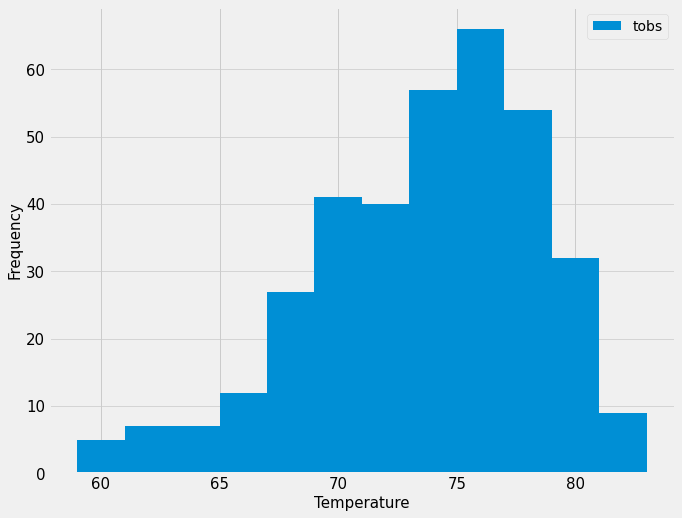

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_time=session.query(Measurement.date).filter(Measurement.station==active_station).order_by(Measurement.date.desc()).first()
station_year=int(station_time[0][:4])
station_month=int(station_time[0][5:7])
station_date=int(station_time[0][8:11])

timepoint2=dt.date(station_year,station_month, station_date)-dt.timedelta(days=365)

result2=session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==active_station).filter(Measurement.date>=timepoint2).all()
date2=[x[0] for x in result2]
temp=[x[1] for x in result2]

station_df=pd.DataFrame({'Date':date2,'Temperature':temp})

plt.figure(figsize=[10,8])
plt.hist(x=station_df['Temperature'], bins=12, label='tobs')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(loc='best')
plt.show()


## Bonus Challenge Assignment

Temperature Analysis I


- Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
- You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
- Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
- Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [23]:
from scipy.stats import ttest_ind

In [24]:
#load the measurement file into panda dataframe
file='Resources/hawaii_measurements.csv'

measure_df=pd.read_csv(file)

measure_df['day']=measure_df['date'].str[-2:].astype(int)
measure_df['month']=measure_df['date'].str[5:7].astype(int)
measure_df['year']=measure_df['date'].str[:4].astype(int)

measure_df.head()

station        date  prcp  tobs  day  month  year
0  USC00519397  2010-01-01  0.08    65    1      1  2010
1  USC00519397  2010-01-02  0.00    63    2      1  2010
2  USC00519397  2010-01-03  0.00    74    3      1  2010
3  USC00519397  2010-01-04  0.00    76    4      1  2010
4  USC00519397  2010-01-06   NaN    73    6      1  2010

In [25]:
june_df=measure_df['tobs'].loc[measure_df['month']==6]
dec_df=measure_df['tobs'].loc[measure_df['month']==12]


print(june_df.mean())
print(dec_df).mean())
ttest_ind(june_df,dec_df)

#based on the results below, as p-value is less than 0.05, null hypothesis (mean temperature between June to December are different) has been rejected
#it makes more sense to use paired t-test in this situation as the population of the data came from the similar locations, measured on 2 different timeframe.

SyntaxError: invalid syntax (<ipython-input-25-9076065577d8>, line 6)

Temperature Analysis II
- The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.
- Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").
- Plot the min, avg, and max temperature from your previous query as a bar chart.
- Use the average temperature as the bar height.
- Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
current_year=calc_temps('2014-05-20', '2014-05-30')
previous_year=calc_temps('2013-05-20', '2013-05-30')

print(f" the minimum temperature, average temperature, and maximum temperature of this year are {current_year[0][0]}, {round(current_year[0][1],2)}, and {current_year[0][2]} respectively.")
print(f" the minimum temperature, average temperature, and maximum temperature of previous year are {previous_year[0][0]}, {round(previous_year[0][1],2)}, and {previous_year[0][2]} respectively.")

 the minimum temperature, average temperature, and maximum temperature of this year are 66.0, 74.47, and 81.0 respectively.
 the minimum temperature, average temperature, and maximum temperature of previous year are 64.0, 74.12, and 82.0 respectively.


<ErrorbarContainer object of 3 artists>

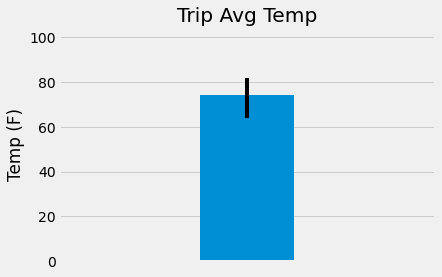

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x=1
plt.bar(x,previous_year[0][1], width=0.5)
plt.xlim(0,2)
plt.ylim(0,float(previous_year[0][1]+30))
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel ('Temp (F)')
plt.errorbar(1,[previous_year[0][2],previous_year[0][0]], color='black')


Daily Rainfall Average
- Calculate the rainfall per weather station using the previous year's matching dates.
- Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
- You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.
- Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
- Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
- Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [108]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_prcp=session.query(Measurement.station,Station.name,func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
    group_by(Measurement.station).filter(Measurement.date >= '2013-05-20').filter(Measurement.station==Station.station).filter(Measurement.date <= '2013-05-30').order_by(func.sum(Measurement.prcp).desc()).all()

total_prcp

[('USC00519281',
  'WAIHEE 837.5, HI US',
  6.33,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  5.97,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  2.23,
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  1.87,
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 1.87, 21.4234, -157.8015, 14.6),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.1, 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 0.04, 21.3934, -157.9751, 11.9),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.0,
  21.3152,
  -157.9992,
  0.9)]

In [110]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [150]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

#convert these dates into string with %m-%d format

# Set the start and end date of the trip
startDate = dt.datetime.strptime('05-20', "%m-%d")
endDate = dt.datetime.strptime('05-30', "%m-%d")
delta = endDate - startDate


# Use the start and end date to create a range of dates
date_range=[]

for i in range(delta.days + 1): #delta.days returns number of days between endDate & startDate. 1 has been added at the end to be inclusive of the end date
    date_range.append(startDate + dt.timedelta(days=i)) #this loop act as a counter to add 1 day from start date from each loop.

# Stip off the year and save a list of %m-%d strings
str_date_range = []
for date in date_range:
    new_date = date.strftime("%m-%d")
    str_date_range.append(new_date)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[daily_normals(x) for x in str_date_range]

# # for x in str_date_range:
# #     normals.append(daily_normals(x))

normals

[[(68.0, 73.89655172413794, 79.0)],
 [(64.0, 72.96428571428571, 80.0)],
 [(64.0, 74.45614035087719, 80.0)],
 [(68.0, 74.94827586206897, 87.0)],
 [(67.0, 73.94827586206897, 79.0)],
 [(68.0, 74.27586206896552, 79.0)],
 [(65.0, 74.03636363636363, 82.0)],
 [(65.0, 74.49090909090908, 80.0)],
 [(67.0, 74.27777777777777, 82.0)],
 [(64.0, 74.19607843137256, 80.0)],
 [(69.0, 74.33333333333333, 81.0)]]

In [151]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

min_tobs=[x[0][0] for x in normals]
avg_tobs=[x[0][1] for x in normals]
max_tobs=[x[0][2] for x in normals]

trip_dates_df=pd.DataFrame({"Date":str_date_range, 'tmin':min_tobs, 'tavg':avg_tobs, 'tmax':max_tobs})
trip_dates_df=trip_dates_df.set_index('Date')
trip_dates_df

tmin       tavg  tmax
Date                        
05-20  68.0  73.896552  79.0
05-21  64.0  72.964286  80.0
05-22  64.0  74.456140  80.0
05-23  68.0  74.948276  87.0
05-24  67.0  73.948276  79.0
05-25  68.0  74.275862  79.0
05-26  65.0  74.036364  82.0
05-27  65.0  74.490909  80.0
05-28  67.0  74.277778  82.0
05-29  64.0  74.196078  80.0
05-30  69.0  74.333333  81.0

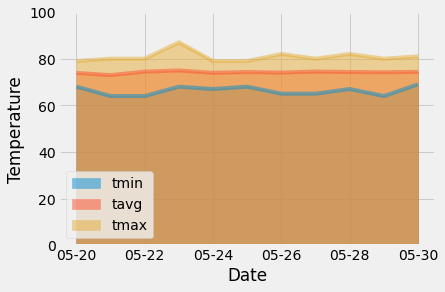

In [157]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_df.plot(kind='area', stacked=False)
plt.ylim(0,100)
plt.ylabel('Temperature')
plt.legend(loc='best')
